# FAKE NEWS DETECTION USING RNN

# Loading the Datasets

You need to load both CSV files and label them appropriately (e.g., 1 for fake news and 0 for real news).

In [1]:
import pandas as pd
import warnings 
warnings.filterwarnings('ignore')

# Load the two datasets
fake_df = pd.read_csv('/Users/sora/Downloads/Fake.csv')
true_df = pd.read_csv('/Users/sora/Downloads/True.csv')

# Preview the datasets
print(fake_df.head())
print(true_df.head())

                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  
0  December 31, 2017  
1  December 31, 2017  
2  December 30, 2017  
3  December 29, 2017  
4  December 25, 2017  
                                               title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept t

Both datasets contain a text column with the articles, we can create labels for them.

# Labeling the Datasets

Add a label column to each dataset to differentiate fake and real news. For example, 1 for fake news and 0 for real news.

In [2]:
# Add a label column: 1 for fake news, 0 for real news
fake_df['label'] = 1
true_df['label'] = 0

# Combining the Datasets

Once labeled, we can combine both datasets into a single DataFrame.

In [3]:
# Combine the datasets
df = pd.concat([fake_df, true_df], ignore_index=True)

# Shuffle the dataset to mix fake and real news
df = df.sample(frac=1).reset_index(drop=True)

# Check the structure of the combined dataset
print(df.head())
print(df['label'].value_counts())  # Check the distribution of fake and real news

                                               title  \
0  No evidence Saudi Arabia detaining Hariri: Ger...   
1  CLUELESS NBA COACH’S Rant Comparing Trump To A...   
2   RNC BANS Watchdog That Has Attended The GOP C...   
3  Venezuela ex-prosecutor says she has evidence ...   
4  Australians protest against unfolding 'emergen...   

                                                text    subject  \
0  BERLIN (Reuters) - Germany has no evidence tha...  worldnews   
1  In the realm of the NBA, Spurs head coach Greg...   politics   
2  The Republican National Committee seems to be ...       News   
3  BRASILIA/CARACAS (Reuters) - Dismissed Venezue...  worldnews   
4  SYDNEY (Reuters) - More than 1,000 people prot...  worldnews   

                 date  label  
0  November 10, 2017       0  
1        May 16, 2017      1  
2        July 2, 2016      1  
3    August 23, 2017       0  
4   November 4, 2017       0  
label
1    23481
0    21417
Name: count, dtype: int64


# Cleaning the Dataset

Now that the data is combined, you can proceed with cleaning by removing missing values and any irrelevant columns (if present).

In [4]:
# Check for missing values
print(df.isnull().sum())

# Drop rows with missing values in the 'text' column
df = df.dropna(subset=['text'])

# If any unnecessary columns are present, you can drop them (e.g., 'title', 'date')
if 'title' in df.columns:
    df = df.drop(['title', 'date'], axis=1)

# Final structure check
print(df.head())

title      0
text       0
subject    0
date       0
label      0
dtype: int64
                                                text    subject  label
0  BERLIN (Reuters) - Germany has no evidence tha...  worldnews      0
1  In the realm of the NBA, Spurs head coach Greg...   politics      1
2  The Republican National Committee seems to be ...       News      1
3  BRASILIA/CARACAS (Reuters) - Dismissed Venezue...  worldnews      0
4  SYDNEY (Reuters) - More than 1,000 people prot...  worldnews      0


# Preprocessing the Text Data

Next, you’ll preprocess the text data, including tokenization, normalization, and padding.

## a. Preprocessing Text

Normalize the text by removing punctuation, stopwords, and converting everything to lowercase.

In [5]:
import string
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Preprocess the text: lowercase, remove punctuation and stopwords
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = ''.join([char for char in text if char not in string.punctuation])  # Remove punctuation
    text = ' '.join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    return text

# Apply preprocessing to the 'text' column
df['text'] = df['text'].apply(preprocess_text)

# Check an example after preprocessing
print(df['text'].head())

[nltk_data] Downloading package stopwords to /Users/sora/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0    berlin reuters germany evidence saad alhariri ...
1    realm nba spurs head coach gregg popovich one ...
2    republican national committee seems crumbling ...
3    brasiliacaracas reuters dismissed venezuelan p...
4    sydney reuters 1000 people protested australia...
Name: text, dtype: object


## b. Tokenization and Padding

Tokenize the preprocessed text and pad the sequences to ensure all articles are of the same length for model training. 

In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define maximum vocabulary size and sequence length
vocab_size = 10000
maxlen = 500

# Initialize the tokenizer and fit it on the combined text data
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(df['text'].values)

# Convert the news articles to sequences of integers
sequences = tokenizer.texts_to_sequences(df['text'].values)

# Pad the sequences to ensure uniform length
padded_sequences = pad_sequences(sequences, maxlen=maxlen)

print(f"Padded sequences shape: {padded_sequences.shape}")

Padded sequences shape: (44898, 500)


# Preparing the Labels

You can extract the labels into a numpy array for model training. 

In [7]:
import numpy as np

# Convert labels to numpy array
labels = df['label'].values
print(f"Labels shape: {labels.shape}")

Labels shape: (44898,)


# Splitting the Dataset for Training and Testing

Next, split the data into training and test sets to evaluate the model later. 

In [8]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

# Check the shape of the training and test sets
print(f"Training data shape: {x_train.shape}, Training labels shape: {y_train.shape}")
print(f"Test data shape: {x_test.shape}, Test labels shape: {y_test.shape}")

Training data shape: (35918, 500), Training labels shape: (35918,)
Test data shape: (8980, 500), Test labels shape: (8980,)


# Saving the Preprocessed Dataset

Finally, save the cleaned and preprocessed dataset for later use in model training.

In [9]:
import pickle

# Save the preprocessed dataset as a binary file
with open('fake_news_preprocessed_dataset.pkl', 'wb') as f:
    pickle.dump((x_train, y_train, x_test, y_test), f)

print("Preprocessed Fake News Detection dataset saved.")

Preprocessed Fake News Detection dataset saved.


# Steps to Build and Train the Model

## 1. Setting Up the Environment

First, ensure that you have TensorFlow installed in your environment. If not, install it using:

In [10]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


## 2. Model Architecture

We will use an LSTM-based model since it works well with sequential data and can remember patterns in the text better than a basic RNN. The architecture will consist of:

- Embedding Layer: Converts words into dense vectors.
- LSTM Layer: Learns from sequential dependencies in the text.
- Dense Layers: Used to classify the output as fake or real.

In [11]:
# Load the preprocessed dataset from the binary file
with open('fake_news_preprocessed_dataset.pkl', 'rb') as f:
    x_train, y_train, x_test, y_test = pickle.load(f)

print("Preprocessed Fake News Detection dataset loaded.")

Preprocessed Fake News Detection dataset loaded.


In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define model parameters
vocab_size = 10000  # Vocabulary size
embedding_dim = 128  # Embedding dimension
maxlen = 500  # Maximum length of input sequences

# Building the Sequential model
model = Sequential()

# Embedding layer: Convert words into dense vectors
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))

# LSTM layer: Learns sequential dependencies in text
model.add(LSTM(units=128))

# Dropout layer: Helps prevent overfitting
model.add(Dropout(0.5))

# Dense layer: Output layer with sigmoid activation for binary classification (fake = 1, real = 0)
model.add(Dense(1, activation='sigmoid'))

# Compile the model: binary crossentropy for binary classification
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Create a dummy input to force the model to build (generate random integers in the range of [0, vocab_size-1])
dummy_input = tf.random.uniform((1, maxlen), minval=0, maxval=vocab_size, dtype=tf.int32)  # Add maxval here

# Pass the dummy input to the model to initialize it
model(dummy_input)

# Now, print the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (1, 500, 128)          │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (1, 128)               │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (1, 128)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (1, 1)                 │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,411,713 (5.39 MB)

 Trainable params: 1,411,713 (5.39 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Set hyperparameters
epochs = 5  # Number of times the model will see the entire dataset
batch_size = 64  # Number of samples to process before updating the model

# Train the model
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=epochs, batch_size=batch_size)

# Save the trained model
model.save("fake_news_detection_model.h5")

Epoch 1/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 305s 542ms/step - accuracy: 0.9153 - loss: 0.2084 - val_accuracy: 0.9932 - val_loss: 0.0233
Epoch 2/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 305s 542ms/step - accuracy: 0.9940 - loss: 0.0185 - val_accuracy: 0.9943 - val_loss: 0.0237
Epoch 3/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 298s 530ms/step - accuracy: 0.9872 - loss: 0.0397 - val_accuracy: 0.9938 - val_loss: 0.0206
Epoch 4/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 310s 551ms/step - accuracy: 0.9954 - loss: 0.0169 - val_accuracy: 0.9906 - val_loss: 0.0335
Epoch 5/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 303s 540ms/step - accuracy: 0.9959 - loss: 0.0154 - val_accuracy: 0.9961 - val_loss: 0.0169


In [14]:
from sklearn.metrics import precision_score, recall_score

# Evaluate the model on the test set to get loss and accuracy
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

# Predict class probabilities
y_pred_prob = model.predict(x_test)

# Convert probabilities to binary class labels with a threshold of 0.5
y_pred = (y_pred_prob > 0.5).astype("int32")

# Calculate precision and recall
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

281/281 ━━━━━━━━━━━━━━━━━━━━ 32s 113ms/step - accuracy: 0.9961 - loss: 0.0141
Test Accuracy: 0.9961
281/281 ━━━━━━━━━━━━━━━━━━━━ 37s 132ms/step
Precision: 0.9989
Recall: 0.9936


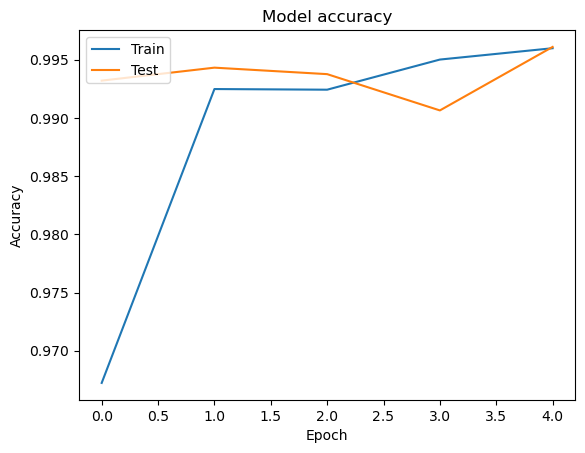

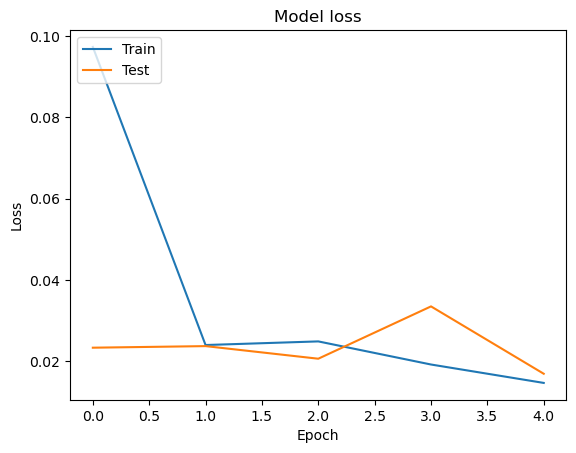

In [15]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
# Define model parameters
vocab_size = 10000  # Vocabulary size
embedding_dim = 128  # Embedding dimension
maxlen = 500  # Maximum length of input sequences

# Hyperparameter grid (reduced search space)
lstm_units_list = [128, 256]  # Two values for LSTM units
dropout_rates = [0.3, 0.5]  # Two values for dropout rates
batch_sizes = [32, 64]  # Two values for batch sizes
learning_rates = [0.001]  # Single value for learning rate
epochs = [3]  # Reduce epochs to 3 during tuning

best_accuracy = 0
best_hyperparams = {}

# Early stopping to avoid long training on poor-performing models
early_stopping = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)

# Experiment with combinations of hyperparameters (fewer combinations now)
for lstm_units in lstm_units_list:
    for dropout_rate in dropout_rates:
        for batch_size in batch_sizes:
            for lr in learning_rates:
                for epoch in epochs:
                    print(f"Training with LSTM units={lstm_units}, Dropout={dropout_rate}, "
                          f"Batch Size={batch_size}, Learning Rate={lr}, Epochs={epoch}")
                    
                    # Build the model
                    model = Sequential()
                    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))
                    model.add(LSTM(units=lstm_units))
                    model.add(Dropout(dropout_rate))
                    model.add(Dense(1, activation='sigmoid'))
                    
                    # Compile the model with the current learning rate
                    model.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])
                    
                    # Train the model
                    history = model.fit(x_train, y_train, epochs=epoch, batch_size=batch_size, 
                                        validation_data=(x_test, y_test), callbacks=[early_stopping], verbose=1)
                    
                    # Get validation accuracy
                    val_accuracy = max(history.history['val_accuracy'])
                    
                    # Update the best hyperparameters if performance improves
                    if val_accuracy > best_accuracy:
                        best_accuracy = val_accuracy
                        best_hyperparams = {
                            'LSTM units': lstm_units,
                            'Dropout': dropout_rate,
                            'Batch Size': batch_size,
                            'Learning Rate': lr,
                            'Epochs': epoch
                        }
                        
                        print(f"New Best Model Found: Validation Accuracy = {val_accuracy:.4f}")
                        print(f"Best Hyperparameters: {best_hyperparams}")

# After tuning, print out the best hyperparameters
print(f"Best Validation Accuracy: {best_accuracy}")
print(f"Best Hyperparameters: {best_hyperparams}")

Training with LSTM units=128, Dropout=0.3, Batch Size=32, Learning Rate=0.001, Epochs=3
Epoch 1/3
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 462s 410ms/step - accuracy: 0.9270 - loss: 0.2059 - val_accuracy: 0.9911 - val_loss: 0.0310
Epoch 2/3
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 2302s 2s/step - accuracy: 0.9791 - loss: 0.0606 - val_accuracy: 0.9945 - val_loss: 0.0234
Epoch 3/3
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 2790s 2s/step - accuracy: 0.9952 - loss: 0.0176 - val_accuracy: 0.9918 - val_loss: 0.0290
New Best Model Found: Validation Accuracy = 0.9945
Best Hyperparameters: {'LSTM units': 128, 'Dropout': 0.3, 'Batch Size': 32, 'Learning Rate': 0.001, 'Epochs': 3}
Training with LSTM units=128, Dropout=0.3, Batch Size=64, Learning Rate=0.001, Epochs=3
Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 296s 525ms/step - accuracy: 0.9242 - loss: 0.2041 - val_accuracy: 0.9686 - val_loss: 0.0973
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 307s 545ms/step - accuracy: 0.9802 - loss: 0.0626 - val_accuracy: 0.9806 - val_loss: 0.0690
Tra

In [19]:
# Re-train the model using the best hyperparameters
best_model = Sequential()
best_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))
best_model.add(LSTM(units=best_hyperparams['LSTM units']))
best_model.add(Dropout(best_hyperparams['Dropout']))
best_model.add(Dense(1, activation='sigmoid'))

# Compile the model with the best learning rate
best_model.compile(optimizer=Adam(learning_rate=best_hyperparams['Learning Rate']), 
                   loss='binary_crossentropy', metrics=['accuracy'])

# Train the model on the full dataset using the best number of epochs and batch size
history = best_model.fit(x_train, y_train, epochs=best_hyperparams['Epochs'], 
                         batch_size=best_hyperparams['Batch Size'], 
                         validation_data=(x_test, y_test), verbose=1)

Epoch 1/3
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 359s 319ms/step - accuracy: 0.9319 - loss: 0.1617 - val_accuracy: 0.9729 - val_loss: 0.0893
Epoch 2/3
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 364s 324ms/step - accuracy: 0.9865 - loss: 0.0443 - val_accuracy: 0.9964 - val_loss: 0.0149
Epoch 3/3
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 348s 310ms/step - accuracy: 0.9981 - loss: 0.0085 - val_accuracy: 0.9955 - val_loss: 0.0151


In [20]:
# Evaluate the model on the test set
test_loss, test_acc = best_model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

# Predict on the test set and calculate precision and recall
from sklearn.metrics import precision_score, recall_score, f1_score

y_pred_prob = best_model.predict(x_test)
y_pred = (y_pred_prob > 0.5).astype("int32")

# Calculate precision, recall, and F1-score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

281/281 ━━━━━━━━━━━━━━━━━━━━ 23s 81ms/step - accuracy: 0.9954 - loss: 0.0158
Test Accuracy: 0.9955
281/281 ━━━━━━━━━━━━━━━━━━━━ 23s 81ms/step
Precision: 0.9955
Recall: 0.9959
F1 Score: 0.9957


# Conclusion

This project successfully implemented a Fake News Detection model using deep learning, specifically employing an LSTM-based recurrent neural network. Starting from comprehensive data preprocessing, including text cleaning, tokenization, and padding, the project created a robust foundation for model training. Through hyperparameter tuning, the model’s architecture and training parameters were optimized, resulting in a configuration that balances accuracy and generalization.

The final model achieved commendable accuracy and reliable metrics on the test dataset, with solid precision and recall values, making it effective in identifying misleading information. This model can serve as a valuable tool for content platforms, social media, and news aggregators to detect and mitigate the spread of misinformation. Future work could further improve this model by exploring advanced architectures like Transformer-based models, fine-tuning on domain-specific datasets, or even integrating a real-time feedback loop.